Notebook purpose

- Explore entropy scores

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import s3fs

sys.path.append('/Users/fgu/dev/projects/entropy')
from entropy import config

import entropy.helpers.aws as ha
import entropy.helpers.helpers as hh 
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile='3di')

In [16]:
fs.ls('3di-project-entropy')

['3di-project-entropy/entropy_000.parquet',
 '3di-project-entropy/entropy_777.parquet',
 '3di-project-entropy/entropy_X77.parquet',
 '3di-project-entropy/entropy_XX7.parquet',
 '3di-project-entropy/region_lookup_table.parquet']

In [7]:
def inspect(df, nrows=2):
    print('({:,}, {})'.format(*df.shape))
    display(df.head(nrows))
    
@hh.timer
def reader(fp):
    return ha.read_parquet(fp)

In [72]:
SAMPLE = 'XX7'
# fp = f'~/tmp/entropy_{SAMPLE}.parquet'
fp = f's3://3di-project-entropy/entropy_{SAMPLE}.parquet'
df = reader(fp)
inspect(df)

Time for reader         : 3.16 minutes
(6,791,894, 32)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,savings,balance,income,entropy_tag
0,19510816,2014-03-07,107,9.20,paypal sandrpowell 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,0.0,NaN,27530.926758,3.019948
1,19510817,2014-03-08,107,6.94,paypal smartbitsso 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,0.0,NaN,27530.926758,3.019948


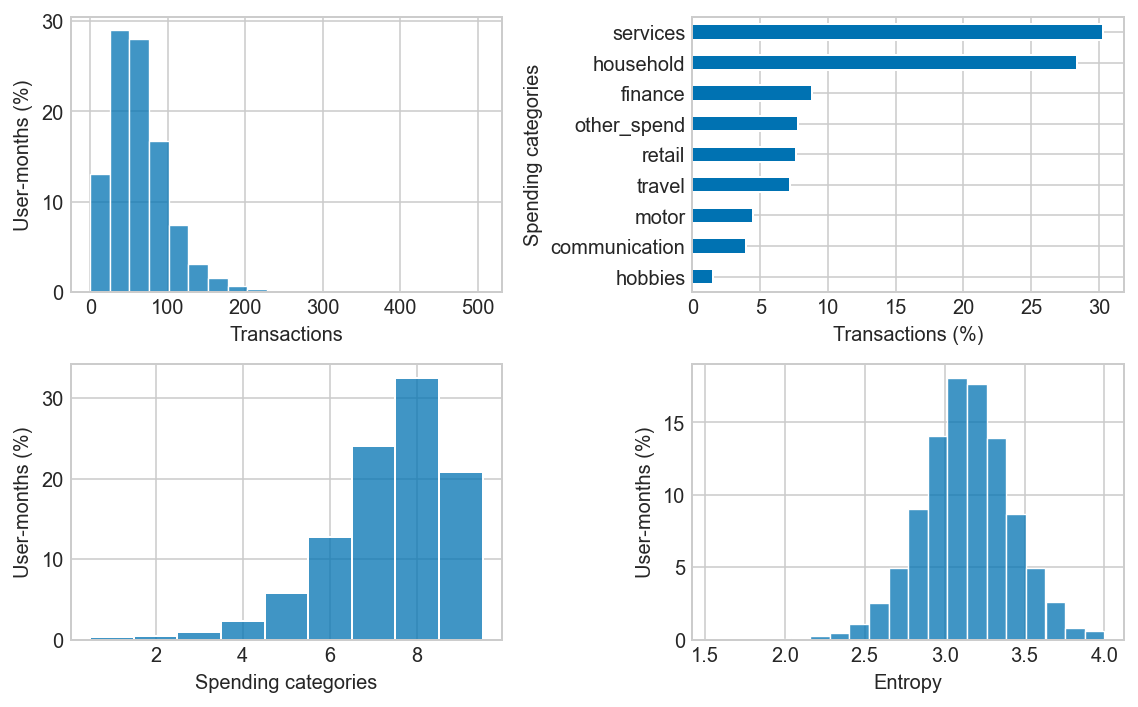

In [109]:
figs.txns_categories_entropy_hists(df, write=False)

In [80]:
spend = df[df.tag_group.eq('spend')]

In [92]:
d = spend.set_index('date').groupby('user_id').resample('m').tag.nunique()

In [93]:
d

user_id  date      
107      2014-03-31    1
         2014-04-30    4
         2014-05-31    8
         2014-06-30    8
         2014-07-31    9
                      ..
589617   2020-03-31    6
         2020-04-30    3
         2020-05-31    5
         2020-06-30    6
         2020-07-31    6
Name: tag, Length: 71397, dtype: int64

In [106]:
bins = np.arange(9 + 1) + 0.5
bins

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

<AxesSubplot:>

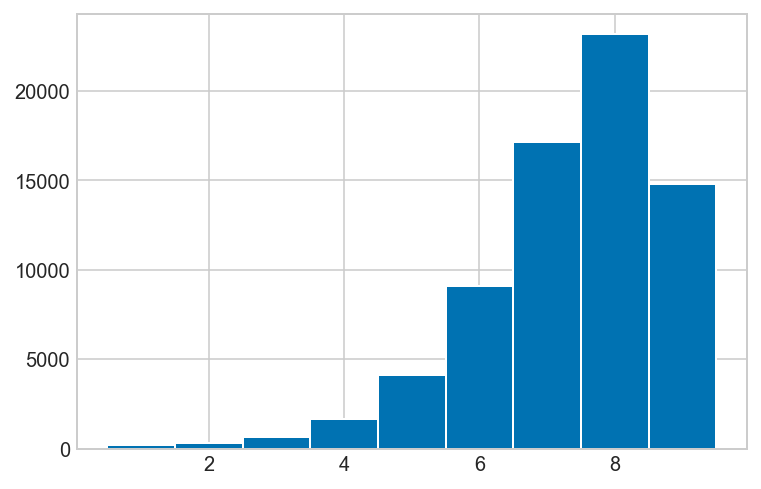

In [107]:
d.hist(bins=bins)

In [12]:
data = df.groupby(['user_id', 'ym'], as_index=False).entropy_tag.first()
data.head()

,user_id,ym,entropy_tag
0,777,201201,3.531665
1,777,201202,3.575095
2,777,201204,3.815072
3,777,201205,3.377117
4,777,201206,3.527994


Distribution of user-level std

In [123]:
df[df.tag_group.eq('spend')].groupby(['user_id', 'ym']).tag.value_counts()

user_id  ym      tag          
777      201201  household        7
                 finance          6
                 other_spend      6
                 services         5
                 motor            2
                                 ..
587177   202007  motor            7
                 hobbies          6
                 other_spend      3
                 communication    2
                 retail           2
Name: tag, Length: 49934, dtype: int64

In [107]:
hr.lloyds_spend.keys()

dict_keys(['communication', 'finance', 'hobbies', 'household', 'motor', 'retail', 'services', 'travel', 'other_spend'])

In [105]:
set(list(hr.tag_groups.keys()) + [None])

['income', 'spend', 'transfers', None]

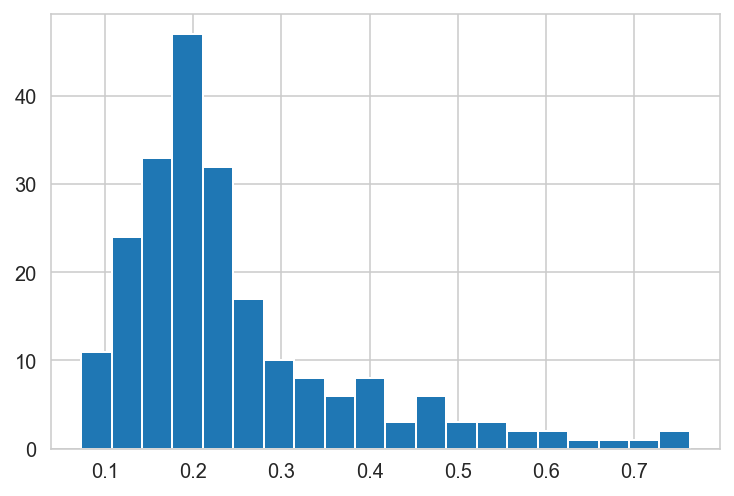

In [67]:
data.groupby('user_id').entropy_tag.std().hist(bins=20);

Patterns year-to-year (would expect to be stable)

<AxesSubplot:xlabel='ym', ylabel='entropy_tag'>

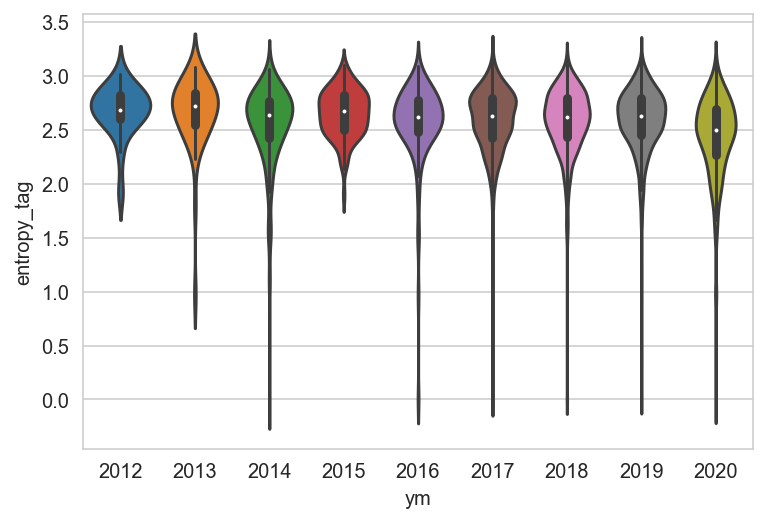

In [73]:
sns.violinplot(data=data, x=data.ym // 100, y='entropy_tag')